## 시계열변환

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## 이상치제거후 데이터 Load

In [3]:
# 이상치제거후 데이터 Load

filename = "SKT_충전데이터_최종_이상치제거후_23.03.08"

print("[*] Load the dataset")

ev_df = pd.read_csv("%s.csv" % filename, engine='python', encoding='cp949')

display(ev_df)

[*] Load the dataset


,운영기관,충전소명,충전소ID,충전기명,충전기ID,충전기타입,충전시작시각,충전종료시각,충전시간,충전량,충전용량,충전소구분,주소,충전시작년월일,충전종료년월일,충전시작분,충전종료분
0,한국전력,스마트그리드 홍보관,KPxxxx,급속03,579,급속,2021-01-01 0:04,2021-01-01 0:20,KPxxxx,3.14,50,공용,제주특별자치도 제주시 구좌읍 행원리 575-20,2021-01-01,2021-01-01,4,20
1,한국전력,서귀포지사,KPxxxx,급속02,8819,급속,2021-01-01 0:46,2021-01-01 2:04,KPxxxx,36.39,50,공용,제주특별자치도 서귀포시 신중로 56,2021-01-01,2021-01-01,46,124
2,한국전력,화북주공2 아파트,KPxxxx,급속01,5844,급속,2021-01-01 1:23,2021-01-01 1:59,KPxxxx,20.58,50,아파트용,제주특별자치도 제주시 동화로1길 39,2021-01-01,2021-01-01,83,119
3,한국전력,제주도교육청,KPxxxx,급속02,8029,급속,2021-01-01 1:28,2021-01-01 3:07,KPxxxx,17.50,50,공용,제주특별자치도 제주시 연동 311-46,2021-01-01,2021-01-01,88,187
4,한국전력,건입현대 아파트,KPxxxx,급속01,3509,급속,2021-01-01 2:02,2021-01-01 3:27,KPxxxx,40.57,50,아파트용,제주특별자치도 제주시 건입동 만덕로3길 26,2021-01-01,2021-01-01,122,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972253,제주특별자치도,한국교통방송 제주본부,JD110036,한국교통방송 제주본부_02,2,DC콤보,2022-06-22 23:15,2022-06-22 23:47,0:32:23,21.15,50,공용,missing,2022-06-22,2022-06-22,1395,1427
972254,제주특별자치도,구좌읍주민센터,JD100011,구좌읍주민센터_01,1,AC급속3상,2022-06-22 23:25,2022-06-22 23:36,0:10:45,6.71,50,공용,missing,2022-06-22,2022-06-22,1405,1416
972255,제주특별자치도,동화초등학교 공영주차장,JD110002,동화초등학교 공영주차장_01,1,DC차데모,2022-06-22 23:28,2022-06-22 23:39,0:10:59,5.34,50,공용,missing,2022-06-22,2022-06-22,1408,1419
972256,제주특별자치도,하귀1리공영주차장,JD110070,하귀1리공영주차장_02,2,AC급속3상,2022-06-22 23:32,2022-06-22 23:51,0:19:13,10.35,50,공용,missing,2022-06-22,2022-06-22,1412,1431


## 시계열변환

In [4]:
def skt_get_ev_ts(
        df,
        start_date = '2021-01-01 00:00:00',
        end_date = '2022-06-22 23:59:00',       
):
    """EV 시계열 행렬 변환.
    
    Parameters
    ----------
    start_date : str, default='2021-01-01 00:00:00'
        시작일자

    end_date : str, default='2022-06-22 23:59:00'
        종료일자

    Returns
    -------
    ts_mtx : DataFrame
        shape = (Days 수, 24).
    """
    idx_day = pd.date_range(start=start_date, end=end_date, freq='D')
    idx_min = pd.date_range(start=start_date, end=end_date, freq='min')
    n_idx_min = len(idx_min)
    if not n_idx_min % 1440 == 0:
        raise ValueError(
            f"The length of n_idx_min should be divided into 1440, but {n_idx_min}."
        )
    # 1분 간격의 zeros 행렬 생성, shape = (1분 간격 수, )
    ts_mtx = np.zeros((n_idx_min,))
    ts_mtx = pd.DataFrame(ts_mtx, index=idx_min, columns=['충전량'])

    # 1분 간격의 시계열 행렬 생성
    for i in range(len(df)):
        sd, ed = df['충전시작년월일'][i], df['충전종료년월일'][i]
        sm, em = df['충전시작분'][i], df['충전종료분'][i]
        ca = df['충전량'][i]
        sr, er = df['충전시작시각'][i], df['충전종료시각'][i]  # 2021-12-01 00:02:00, 2021-12-01 00:27:00

        if sd == ed:
            # Case 1: sd = 2021-12-01, ed = 2021-12-01, sm = 2, em = 27            
            l = em - sm + 1  # 충전량을 분배할 분 길이
            v = ca / l  # 분당 분배된 충전량

            ts_mtx.loc[sr:er, '충전량'] = v + ts_mtx.loc[sr:er, '충전량']

        else:
            # Case 2: sd = 2021-12-01, ed = 2021-12-02, sm = 1418, em = 18            
            l = (1439 - sm + 1) + (em + 1)
            v = ca / l

            ts_mtx.loc[sr:er, '충전량'] = v + ts_mtx.loc[sr:er, '충전량']

    # 최종 ev 시계열 행렬, shape = (Days 수, 24)
    ts_mtx = np.reshape(ts_mtx.values, [len(idx_day), 24, 60])
    ts_mtx = np.sum(ts_mtx, axis=-1)
    ts_mtx = pd.DataFrame(ts_mtx, index=idx_day)

    return ts_mtx

In [5]:
# 원하는 충전소명 입력
idv = ev_df.loc[ev_df['충전소명'] == '스마트그리드 홍보관', :]
idv.reset_index(drop=True, inplace=True)

ts_mtx = skt_get_ev_ts(idv)

display(ts_mtx)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01,3.140,0.0,0.0,0.0,0.00,0.0,6.206897,8.793103,0.000000,11.730000,...,9.581731,17.105484,0.000000,21.384211,9.269688,16.686102,0.0,0.000000,0.000000,0.000
2021-01-02,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,1.067397,...,0.000000,19.594883,39.340979,4.544138,0.000000,0.000000,0.0,0.000000,0.000000,0.000
2021-01-03,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,...,15.297793,20.342609,12.883652,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000
2021-01-04,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,19.215455,8.354545,0.000000,14.460000,0.000000,0.0,0.000000,0.000000,0.000
2021-01-05,0.000,0.0,0.0,0.0,2.29,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12.910000,0.000000,0.000000,0.0,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-18,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,13.753765,25.665709,...,6.127888,0.000000,2.780000,8.709787,30.740426,22.499787,0.0,0.000000,0.000000,4.595
2022-06-19,4.595,0.0,0.0,0.0,0.00,0.0,10.760000,0.000000,0.000000,0.000000,...,33.659231,6.230769,8.177778,25.680889,4.329667,6.521667,0.0,0.000000,0.000000,0.000
2022-06-20,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,24.430000,0.000000,...,0.000000,0.000000,12.710000,5.786458,5.323542,0.000000,0.0,0.000000,0.000000,0.000
2022-06-21,0.000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,...,8.065200,10.627273,39.900727,24.229692,6.081399,3.450909,0.0,14.118966,7.431034,0.000


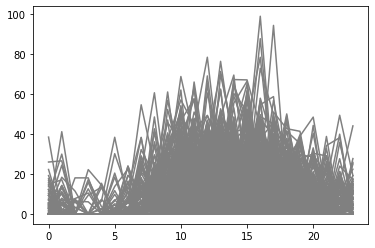

In [10]:
fig, ax = plt.subplots()
ax.plot(ts_mtx.T, c='grey');